<a href="https://colab.research.google.com/github/lily-the-real-lilly/first/blob/main/CovidResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How did a region's population density affect their Covid infection rate? Can we use the number of confirmed cases in the first year and population density to predict infection rate?

Null Hypothesis: There is no statistically significant correlation between population density and Covid infection rates.

Alternative Hypothesis: There is a statistically significant correlation between population density and Covid infection rates.

# Loading In

In [53]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
!pip install scikit-learn
from sklearn import datasets, model_selection
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

In [54]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
covid_df = pd.read_csv(url)
covid_df.head(20)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
5,NaN,Antarctica,-71.949900,23.347000,0,0,0,0,0,0,...,11,11,11,11,11,11,11,11,11,11
6,NaN,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,...,9106,9106,9106,9106,9106,9106,9106,9106,9106,9106
7,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,...,10044125,10044125,10044125,10044125,10044125,10044125,10044957,10044957,10044957,10044957
8,NaN,Armenia,40.069100,45.038200,0,0,0,0,0,0,...,446819,446819,446819,446819,446819,446819,446819,446819,447308,447308
9,Australian Capital Territory,Australia,-35.473500,149.012400,0,0,0,0,0,0,...,232018,232018,232619,232619,232619,232619,232619,232619,232619,232974




---



# Datetime() Stuff

In [55]:
#get all dat columns in separate df
date_df = covid_df.iloc[:,4:]
firstfour = covid_df.iloc[:, 0:4]
date_df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,0,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,0,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,0,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,0,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,0,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [56]:
#convert dates to proper date time format
date_df.columns = pd.to_datetime(date_df.columns)
date_df.head()

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2023-02-28,2023-03-01,2023-03-02,2023-03-03,2023-03-04,2023-03-05,2023-03-06,2023-03-07,2023-03-08,2023-03-09
0,0,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,0,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,0,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,0,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,0,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [57]:
#group columns by year and aggregate
date_df = date_df.groupby(date_df.columns.year, axis=1).sum()
date_df.head()

,2020,2021,2022,2023
0,8501751,39518380,67783564,14184774
1,3727544,51106141,108004674,22724295
2,10583375,57172988,96532073,18453214
3,682822,5084330,15527738,3252635
4,1343410,14797145,36733077,7151571


In [58]:
#make a copy of date_df and add back the first 4 columns of the original df
df = date_df.copy()
regrouped = pd.concat([firstfour, date_df], axis =1)
regrouped.head(5)

,Province/State,Country/Region,Lat,Long,2020,2021,2022,2023
0,NaN,Afghanistan,33.93911,67.709953,8501751,39518380,67783564,14184774
1,NaN,Albania,41.15330,20.168300,3727544,51106141,108004674,22724295
2,NaN,Algeria,28.03390,1.659600,10583375,57172988,96532073,18453214
3,NaN,Andorra,42.50630,1.521800,682822,5084330,15527738,3252635
4,NaN,Angola,-11.20270,17.873900,1343410,14797145,36733077,7151571


# Dropping Stuff

In [59]:
droppedstate = regrouped.drop("Province/State", axis = 1)
droppedstate.head()

,Country/Region,Lat,Long,2020,2021,2022,2023
0,Afghanistan,33.93911,67.709953,8501751,39518380,67783564,14184774
1,Albania,41.15330,20.168300,3727544,51106141,108004674,22724295
2,Algeria,28.03390,1.659600,10583375,57172988,96532073,18453214
3,Andorra,42.50630,1.521800,682822,5084330,15527738,3252635
4,Angola,-11.20270,17.873900,1343410,14797145,36733077,7151571


In [60]:
droppedstate[droppedstate['Country/Region'] == "Australia"] #Checking to make sure there are duplicates #this is the before

,Country/Region,Lat,Long,2020,2021,2022,2023
9,Australia,-35.4735,149.0124,31115,236803,52065199,15669403
10,Australia,-33.8688,151.2093,1062399,11035814,959337978,263661840
11,Australia,-12.4634,130.8456,10119,67376,26219000,7098463
12,Australia,-27.4698,153.0251,311736,686462,435655307,121185659
13,Australia,-34.9285,138.6007,132836,336089,193297548,59458095
14,Australia,-42.8821,147.3272,61454,88466,62500054,19346892
15,Australia,-37.8136,144.9631,3296025,15608951,714097705,194693571
16,Australia,-31.9505,115.8605,185540,373662,263892268,87161052


In [61]:
contgrouped = droppedstate.groupby('Country/Region').sum().reset_index()
contgrouped[contgrouped['Country/Region'] == "Australia"]

,Country/Region,Lat,Long,2020,2021,2022,2023
9,Australia,-256.8502,1130.8439,5091224,28433623,2707065059,768274975


In [62]:
contgrouped.info() #no nulls yay

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country/Region  201 non-null    object 
 1   Lat             201 non-null    float64
 2   Long            201 non-null    float64
 3   2020            201 non-null    int64  
 4   2021            201 non-null    int64  
 5   2022            201 non-null    int64  
 6   2023            201 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 11.1+ KB


In [63]:
#onlycont = contgrouped.drop([])
#contgrouped[contgrouped['Country/Region'] == 'Winter Olympics 2022']
# drop 'Antarctica', 'Diamond Princess', 'MS Zaandam' , 'Summer Olympics 2020',  'Winter Olympics 2022'
# ROW 5, 49, 107, 170, 197
df = contgrouped.drop([5, 49, 107, 170, 197])
df[df['Country/Region'] == 'Winter Olympics 2022'] #does work because omlypics does not exist anymore

,Country/Region,Lat,Long,2020,2021,2022,2023


# Region Mapping

In [64]:
region_mapping = {
    'Algeria': 'North Africa',
    'Egypt': 'North Africa',
    'Libya': 'North Africa',
    'Morocco': 'North Africa',
    'Sudan': 'North Africa',
    'Tunisia': 'North Africa',
    'Benin': 'West Africa',
    'Burkina Faso': 'West Africa',
    'Cabo Verde': 'West Africa',
    "Cote d'Ivorie": 'West Africa',
    'Gambia': 'West Africa',
    'Ghana': 'West Africa',
    'Guinea': 'West Africa',
    'Guinea-Bissau': 'West Africa',
    'Liberia': 'West Africa',
    'Mali': 'West Africa',
    'Mauritania': 'West Africa',
    'Niger' : 'West Africa',
    'Nigeria': 'West Africa',
    'Senegal': 'West Africa',
    'Sierra Leone': 'West Africa',
    'Togo': 'West Africa',
    'Burundi': 'East Africa',
    'Comoros': 'East Africa',
    'Djibouti': 'East Africa',
    'Eritrea': 'East Africa',
    'Ethiopia': 'East Africa',
    'Kenya': 'East Africa',
    'Madagascar': 'East Africa',
    'Malawi': 'East Africa',
    'Mauritius': 'East Africa',
    'Mozambique': 'East Africa',
    'Rwanda': 'East Africa',
    'Seychelles': 'East Africa',
    'Somalia': 'East Africa',
    'South Sudan': 'East Africa',
    'Tanzania': 'East Africa',
    'Uganda': 'East Africa',
    'Zambia': 'East Africa',
    'Zimbabwe': 'East Africa',
    'Angola': 'Central Africa',
    'Cameroon':'Central Africa',
    'Central African Republic': 'Central Africa',
    'Chad': 'Central Africa',
    'Congo (Brazzaville)': 'Central Africa',
    'Congo (Kinshasa)': 'Central Africa',
    'Equatorial Guinea': 'Central Africa',
    'Gabon': 'Central Africa',
    'Sao Tome and Principe': 'Central Africa',
    'Botswana': 'South Africa',
    'Eswantini': 'South Africa',
    'Lesotho': 'South Africa',
    'Namibia': 'South Africa',
    'South Africa': 'South Africa',
    'Canada': 'North America',
    'United States': 'North America',
    'Mexico': 'North America',
    'Belize': 'Central America',
    'Costa Rica': 'Central America',
    'El Salvador': 'Central America',
    'Guatemala': 'Central America',
    'Honduras': 'Central America',
    'Nicaragua': 'Central America',
    'Panama Caribbean': 'Central America',
    'Antigua and Barbuda': 'Central America',
    'Bahamas': 'Central America',
    'Barbados': 'Central America',
    'Cuba': 'Central America',
    'Dominica': 'Central America',
    'Dominican Republic': 'Central America',
    'Grenada': 'Central America',
    'Haiti': 'Central America',
    'Jamaica': 'Central America',
    'Saint Kitts and Nevis': 'Central America',
    'Saint Lucia': 'Central America',
    'Saint Vincent and the Grenadines': 'Central America',
    'Trinidad and Tobago': 'Central America',
    'Argentina': 'South America',
    'Bolivia': 'South America',
    'Brazil': 'South America',
    'Chile': 'South America',
    'Colombia': 'South America',
    'Ecuador': 'South America',
    'Guyana': 'South America',
    'Paraguay': 'South America',
    'Peru': 'South America',
    'Suriname': 'South America',
    'Uruguay': 'South America',
    'Venezuela': 'South America',
    'Bahrain': 'Middle East',
    'Iran': 'Middle East',
    'Iraq': 'Middle East',
    'Israel': 'Middle East',
    'Jordan': 'Middle East',
    'Kuwait': 'Middle East',
    'Lebanon': 'Middle East',
    'Oman': 'Middle East',
    'Palestine (West Bank and Gaza)': 'Middle East',
    'Qatar': 'Middle East',
    'Saudi': 'Middle East',
    'Arabia': 'Middle East',
    'Syria': 'Middle East',
    'United Arab Emirates': 'Middle East',
    'Yemen': 'Middle East',
    'Turkey': 'Middle East',
    'Kazakhstan': 'Central Asia',
    'Tajikistan': 'Central Asia',
    'Uzbekistan': 'Central Asia',
    'Afghanistan': 'South Asia',
    'Bangladesh': 'South Asia',
    'Bhutan': 'South Asia',
    'India': 'South Asia',
    'Maladives': 'South Asia',
    'Nepal': 'South Asia',
    'Pakistan': 'South Asia',
    'Sri Lanka': 'South Asia',
    'Brunei': 'Southeast Asia',
    'Burma': 'Southeast Asia',
    'Cambodia': 'Southeast Asia',
    'Indonesia': 'Southeast Asia',
    'Laos': 'Southeast Asia',
    'Malaysia': 'Southeast Asia',
    'Philippines': 'Southeast Asia',
    'Singapore': 'Southeast Asia',
    'Thailand': 'Southeast Asia',
    'Timor-Leste': 'Southeast Asia',
    'Vietnam': 'Southeast Asia',
    'China': 'East Asia',
    'Japan': 'East Asia',
    'Korea, South': 'East Asia',
    'Korea, North': 'East Asia',
    'Mongolia': 'East Asia',
    'Taiwan*': 'East Asia',
    'Denmark': 'North Europe',
    'Estonia': 'North Europe',
    'Finland': 'North Europe',
    'Iceland': 'North Europe',
    'Latvia': 'North Europe',
    'Lithuania': 'North Europe',
    'Norway': 'North Europe',
    'Sweden': 'North Europe',
    'United Kingdom': 'North Europe',
    'Austria': 'West Europe',
    'Belgium': 'West Europe',
    'France': 'West Europe',
    'Germany': 'West Europe',
    'Liechtenstein': 'West Europe',
    'Luxembourg': 'West Europe',
    'Monaco': 'West Europe',
    'Netherlands': 'West Europe',
    'Switzerland': 'West Europe',
    'Albania': 'South Europe',
    'Andorra': 'South Europe',
    'Bosnia and Herzegovina': 'South Europe',
    'Croatia': 'South Europe',
    'Greece': 'South Europe',
    'Holy See': 'South Europe',
    'Italy': 'South Europe',
    'Kosovo': 'South Europe',
    'Malta': 'South Europe',
    'Montenegro': 'South Europe',
    'North Macedonia': 'South Europe',
    'Portugal': 'South Europe',
    'San Marino': 'South Europe',
    'Serbia': 'South Europe',
    'Slovenia': 'South Europe',
    'Spain': 'South Europe',
    'Armenia': 'East Europe',
    'Azerbaijan': 'East Europe',
    'Belarus': 'East Europe',
    'Bulgaria': 'East Europe',
    'Czechia': 'East Europe',
    'Georgia': 'East Europe',
    'Hungary': 'East Europe',
    'Moldova': 'East Europe',
    'Poland': 'East Europe',
    'Romania': 'East Europe',
    'Russia': 'East Europe',
    'Slovakia': 'East Europe',
    'Ukraine': 'East Europe',
    'Australia': 'Australia and New Zealand',
    'Fiji': 'Melanesia',
    'Papua New Guinea': 'Melanesia',
    'Solomon Islands': 'Melanesia',
    'Vanuatu': 'Melanesia',
    'Kiribati': 'Mirconesia',
    'Marshall Islands': 'Mirconesia',
    'Mirconesia': 'Mirconesia',
    'Nauru': 'Mirconesia',
    'Palau': 'Mirconesia',
    'Samoa': 'Polynesia',
    'Tonga': 'Polynesia',
    'Tuvalu': 'Polynesia',
}

In [65]:
df['Place'] = df['Country/Region'].map(region_mapping)
regiongroup = df.groupby('Place').sum().reset_index()
cleaned = regiongroup.drop(columns=['Country/Region'])
                                   # 'new_column'])
cleaned.head(22) #only 19 rows now

,Place,Lat,Long,2020,2021,2022,2023
0,Australia and New Zealand,-256.850200,1130.843900,5091224,28433623,2707065059,768274975
1,Central Africa,11.477800,135.124400,12787160,79649071,155931422,30291845
2,Central America,299.675580,-1389.051083,79000715,723194389,1753160030,377611787
3,Central Asia,128.258091,202.785062,37392324,274424283,608637219,119909509
4,East Africa,-81.663827,695.328823,36757108,397453869,905585126,180707408
5,East Asia,1268.307281,4307.314346,54384615,571722027,13502293410,5292604892
6,East Europe,619.797910,453.052656,619790637,6410781583,16803981180,3573359856
7,Melanesia,-49.050793,649.135950,93300,13958895,48944487,10346595
8,Middle East,376.740971,586.334491,462795579,5255517210,12677530130,2598387677
9,Mirconesia,10.753300,303.964500,208,2744,5666684,2121220



🌏 Oceania
Australia & New Zealand: Australia, New Zealand
Melanesia: Fiji, Papua New Guinea, Solomon Islands, Vanuatu
Micronesia: Kiribati, Marshall Islands, Micronesia, Nauru, Palau
Polynesia: Samoa, Tonga, Tuvalu

In [66]:
cleaned['Place'].unique()

array(['Australia and New Zealand', 'Central Africa', 'Central America',
       'Central Asia', 'East Africa', 'East Asia', 'East Europe',
       'Melanesia', 'Middle East', 'Mirconesia', 'North Africa',
       'North America', 'North Europe', 'Polynesia', 'South Africa',
       'South America', 'South Asia', 'South Europe', 'Southeast Asia',
       'West Africa', 'West Europe'], dtype=object)



---



# Pop & Slope Impute

In [67]:
dropcords = cleaned.drop(['Lat','Long'], axis = 1)
dropcords.head(2)

,Place,2020,2021,2022,2023
0,Australia and New Zealand,5091224,28433623,2707065059,768274975
1,Central Africa,12787160,79649071,155931422,30291845


In [68]:
dropcords.iloc[21:22]

,Place,2020,2021,2022,2023


In [69]:
dropcords['Cases/Year'] = [254394583.7, 5834895, 99537024, 27505728.33, 47983433.33,
                            1746073426, 984523073, 3417765, 711864032.7, 707004,
                            58492631.67, 204851986.3, 755302092.7, 809620, 62136120.67, 1029434649, 721589635.3, 1152167367, 759950407, 8944301, 2140079785]
dropcords.head()

,Place,2020,2021,2022,2023,Cases/Year
0,Australia and New Zealand,5091224,28433623,2707065059,768274975,2.543946e+08
1,Central Africa,12787160,79649071,155931422,30291845,5.834895e+06
2,Central America,79000715,723194389,1753160030,377611787,9.953702e+07
3,Central Asia,37392324,274424283,608637219,119909509,2.750573e+07
4,East Africa,36757108,397453869,905585126,180707408,4.798343e+07


In [70]:
dropcords['Avg People/Sq Km'] = [4, 108, 210, 159, 190, 314, 86, 31, 222, 257, 53, 35, 65, 219, 40, 24, 557, 334, 885, 104, 3107]
dropcords.head(5)

,Place,2020,2021,2022,2023,Cases/Year,Avg People/Sq Km
0,Australia and New Zealand,5091224,28433623,2707065059,768274975,2.543946e+08,4
1,Central Africa,12787160,79649071,155931422,30291845,5.834895e+06,108
2,Central America,79000715,723194389,1753160030,377611787,9.953702e+07,210
3,Central Asia,37392324,274424283,608637219,119909509,2.750573e+07,159
4,East Africa,36757108,397453869,905585126,180707408,4.798343e+07,190


In [71]:
bins = [707004, 428581603, 856456202, 1284330801, 1712205400, 2140080000]
labels = ['1', '2', '3', '4', '5']

dropcords['Infection Speed'] = pd.cut(dropcords['Cases/Year'], bins=bins, labels=labels, include_lowest=True)
dropcords.head()

,Place,2020,2021,2022,2023,Cases/Year,Avg People/Sq Km,Infection Speed
0,Australia and New Zealand,5091224,28433623,2707065059,768274975,2.543946e+08,4,1
1,Central Africa,12787160,79649071,155931422,30291845,5.834895e+06,108,1
2,Central America,79000715,723194389,1753160030,377611787,9.953702e+07,210,1
3,Central Asia,37392324,274424283,608637219,119909509,2.750573e+07,159,1
4,East Africa,36757108,397453869,905585126,180707408,4.798343e+07,190,1


# Fix Province/State

In [114]:
df.head()

,Country/Region,Lat,Long,2020,2021,2022,2023,Place
0,Afghanistan,33.93911,67.709953,8501751,39518380,67783564,14184774,South Asia
1,Albania,41.15330,20.168300,3727544,51106141,108004674,22724295,South Europe
2,Algeria,28.03390,1.659600,10583375,57172988,96532073,18453214,North Africa
3,Andorra,42.50630,1.521800,682822,5084330,15527738,3252635,South Europe
4,Angola,-11.20270,17.873900,1343410,14797145,36733077,7151571,Central Africa


In [115]:
#dropnull = regrouped.dropna(axis = 0, how = 'any', subset = ['Province/State'])
#dropnull.head(5)

In [118]:
LRdroplat = df.drop(['Lat', 'Long'], axis = 1)
LRdroplat.shape

(196, 6)

In [232]:
LRsort = LRdroplat.sort_values(by='Place')
LRindexed = LRsort.reset_index()
LRdropindex = LRindexed.drop(['index'], axis =1)
#LRdata.iloc[59:70] #59
#LRdata[LRdata['Country/Region'] == 'Tajikistan']
LRnodata = LRdropindex.drop([190,195])
LRdata = LRnodata.reset_index()

In [233]:
LRdata['Country People/Sq Km'] = [4, 17, 233, 14, 8, 58, 63, 9, 17, 28, 104, 291, 262, 90, 290, 180, 231, 415,
                                  302, 210, 55, 99, 95, 17, 343, 656, 165, 74, 261, 70, 81, 7, 19, 271, 26, 28, 123,
                                  92, 48, 72, 41, 444, 28, 558, 41, 233, 506, 629, 51, 215, 332, 218, 523, 2, 148, 668,
                                  107, 101, 125, 124, 83, 63, 9, 72, 92, 63, 111, 137, 55, 22, 26, 50, 25, 255, 560, 125,
                                  248, 15, 417, 120, 54, 71, 1943, 141, 112, 100, 587, 226, 39, 178, 77, 112, 18, 83, 4,
                                  27, 65, 4, 18, 4, 280, 25, 18, 31, 45, 138, 30, 336, 162, 159, 50, 4, 74, 3, 4, 16, 26, 31,
                                  20, 71, 4, 11, 46, 26, 16, 25, 363, 62, 1296, 20, 200, 313, 477, 74, 103, 168, 63, 70, 80, 95,
                                  201, 158, 104, 89, 1265, 113, 562, 44, 1669, 140, 316, 378, 78, 82, 94, 91, 32,
                                  105, 8274, 145, 242, 114, 19, 120, 55, 81, 74, 128, 56, 165, 4, 90, 258, 144, 18, 249, 530, 120,
                                  383, 241, 109, 169, 25917, 244, 94, 143, 69, 74, 36, 1723, 19, 59, 14, 37]

In [241]:
LRdata['Slope between 2020 and 2022'] = ((LRdata[2022] - LRdata[2020]) / 2)
LRdata.head(194)

,index,Country/Region,2020,2021,2022,2023,Place,Country People/Sq Km,Slope between 2020 and 2022,Infection Speed
0,0,Australia,5091224,28433623,2707065059,768274975,Australia and New Zealand,4,1.350987e+09,Very Slow
1,1,Congo (Brazzaville),896698,4645968,8890710,1715920,Central Africa,17,3.997006e+06,Very Slow
2,2,Sao Tome and Principe,194089,935257,2196905,427027,Central Africa,233,1.001408e+06,Very Slow
3,3,Chad,277903,1708527,2698075,520825,Central Africa,14,1.210086e+06,Very Slow
4,4,Central African Republic,954949,2996575,5346591,1044663,Central Africa,8,2.195821e+06,Very Slow
...,...,...,...,...,...,...,...,...,...,...
189,189,Maldives,1778957,21538660,63579238,12628661,NaN,1723,3.090014e+07,Very Slow
190,191,New Zealand,471402,1597636,439035740,148678731,NaN,19,2.192822e+08,Very Slow
191,192,Panama,22771266,147752358,317955672,69988513,NaN,59,1.475922e+08,Very Slow
192,193,Saudi Arabia,64831531,172538695,282547839,56323007,NaN,14,1.088582e+08,Very Slow


In [237]:
bins = [
    116.0,
    3_011_770_092.8,
    6_023_540_069.6,
    9_035_310_046.4,
    12_047_080_023.2,
    15_058_850_000.0
]
labels = ['Very Slow', 'Slow', 'Average', 'Fast', 'Very Fast']

LRdata['Infection Speed'] = pd.cut(LRdata['Slope between 2020 and 2022'], bins=bins, labels=labels, include_lowest=True)
LRdata.head()

,index,Country/Region,2020,2021,2022,2023,Place,Country People/Sq Km,Slope between 2020 and 2022,Infection Speed
0,0,Australia,5091224,28433623,2707065059,768274975,Australia and New Zealand,4,1.350987e+09,Very Slow
1,1,Congo (Brazzaville),896698,4645968,8890710,1715920,Central Africa,17,3.997006e+06,Very Slow
2,2,Sao Tome and Principe,194089,935257,2196905,427027,Central Africa,233,1.001408e+06,Very Slow
3,3,Chad,277903,1708527,2698075,520825,Central Africa,14,1.210086e+06,Very Slow
4,4,Central African Republic,954949,2996575,5346591,1044663,Central Africa,8,2.195821e+06,Very Slow


# Stat Anaz

In [229]:
dropcords.corr(numeric_only = True)

,2020,2021,2022,2023,Cases/Year,Avg People/Sq Km
2020,1.000000,0.978109,0.743936,0.613456,0.466290,0.147506
2021,0.978109,1.000000,0.823572,0.687199,0.553730,0.233418
2022,0.743936,0.823572,1.000000,0.966313,0.918111,0.594589
2023,0.613456,0.687199,0.966313,1.000000,0.984668,0.611376
Cases/Year,0.466290,0.553730,0.918111,0.984668,1.000000,0.652264
Avg People/Sq Km,0.147506,0.233418,0.594589,0.611376,0.652264,1.000000


In [230]:
LRdata.corr(numeric_only = True)

,index,2020,2021,2022,2023,Country People/Sq Km,Slope between 2020 and 2022
index,1.000000,0.165222,0.169518,0.190892,0.177337,0.135309,0.171893
2020,0.165222,1.000000,0.990880,0.917312,0.863589,-0.022516,0.780134
2021,0.169518,0.990880,1.000000,0.938966,0.885000,-0.025592,0.809358
2022,0.190892,0.917312,0.938966,1.000000,0.986553,-0.026031,0.956806
2023,0.177337,0.863589,0.885000,0.986553,1.000000,-0.024008,0.989147
Country People/Sq Km,0.135309,-0.022516,-0.025592,-0.026031,-0.024008,1.000000,-0.023228
Slope between 2020 and 2022,0.171893,0.780134,0.809358,0.956806,0.989147,-0.023228,1.000000


# Linear Regression

In [209]:
from sklearn.linear_model import LinearRegression

In [210]:
label = LRdata['Slope between 2020 and 2022']
features = LRdata[['Country People/Sq Km']]

In [211]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, label, test_size=0.2, random_state=42)

In [212]:
lr_model = LinearRegression()

In [213]:
lr_model.fit(X_train, y_train)

LinearRegression()

In [214]:
pred = lr_model.predict(X_test)


In [216]:
LRdata['Slope between 2020 and 2022'].describe()

,Slope between 2020 and 2022
count,1.940000e+02
mean,4.862177e+08
std,1.450020e+09
min,1.160000e+02
25%,7.539378e+06
50%,5.493690e+07
75%,2.681949e+08
max,1.505885e+10


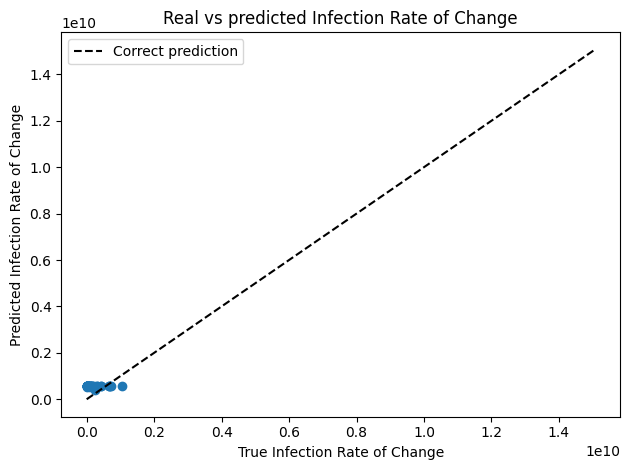

In [221]:
plt.scatter(y_test, pred)
plt.plot([1.160000e+02, 1.505885e+10], [1.160000e+02, 1.505885e+10], '--k', label="Correct prediction")


plt.axis('tight')


plt.xlabel('True Infection Rate of Change')
plt.ylabel('Predicted Infection Rate of Change')
plt.title("Real vs predicted Infection Rate of Change")

plt.legend()
plt.tight_layout()


In [218]:
print('mean squared: ', mean_squared_error(y_test, pred))

print('mean absolute: ', mean_absolute_error(y_test, pred))

print('R2 score: ', r2_score(y_test, pred))

mean squared:  2.099525608735577e+17
mean absolute:  429644517.78819984
R2 score:  -2.250366903173131


* Mean Squared =
* Mean Absolute =
* R2 Score = Not Satisfactory

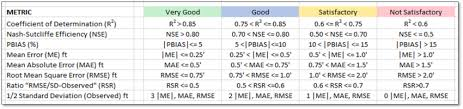

# Final Visualizations

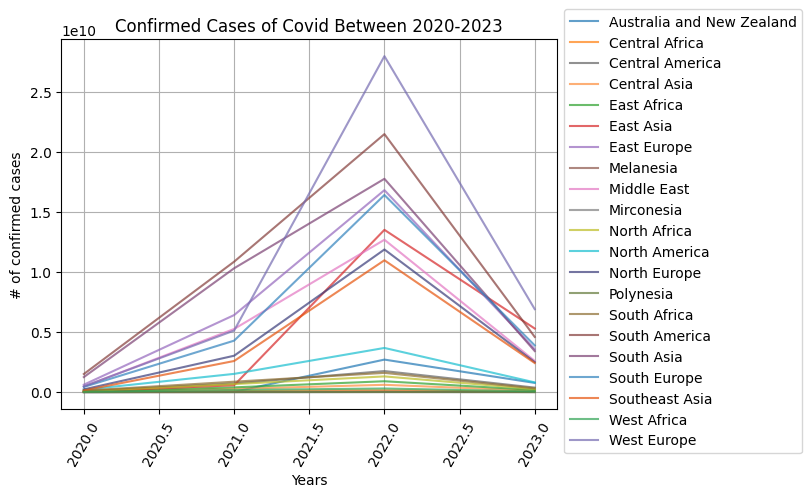

In [81]:
years = [2020, 2021, 2022, 2023]


AuNZ_values = [cleaned.iloc[0, 3], cleaned.iloc[0, 4], cleaned.iloc[0, 5], cleaned.iloc[0, 6]]

CenAf_values = [cleaned.iloc[1, 3], cleaned.iloc[1, 4], cleaned.iloc[1, 5], cleaned.iloc[1, 6]]

CenAm_values = [cleaned.iloc[2, 3], cleaned.iloc[2, 4], cleaned.iloc[2, 5], cleaned.iloc[2, 6]]

CenAs_values = [cleaned.iloc[3, 3], cleaned.iloc[3, 4], cleaned.iloc[3, 5], cleaned.iloc[3, 6]]

EaAf_values = [cleaned.iloc[4, 3], cleaned.iloc[4, 4], cleaned.iloc[4, 5], cleaned.iloc[4, 6]]

EaAs_values = [cleaned.iloc[5, 3], cleaned.iloc[5, 4], cleaned.iloc[5, 5], cleaned.iloc[5, 6]]

EaEu_values = [cleaned.iloc[6, 3], cleaned.iloc[6, 4], cleaned.iloc[6, 5], cleaned.iloc[6, 6]]

Mel_values = [cleaned.iloc[7, 3], cleaned.iloc[7, 4], cleaned.iloc[7, 5], cleaned.iloc[7, 6]]

MiEa_values = [cleaned.iloc[8, 3], cleaned.iloc[8, 4], cleaned.iloc[8, 5], cleaned.iloc[8, 6]]

Mirco_values = [cleaned.iloc[9, 3], cleaned.iloc[9, 4], cleaned.iloc[9, 5], cleaned.iloc[9, 6]]

NoAf_values = [cleaned.iloc[10, 3], cleaned.iloc[10, 4], cleaned.iloc[10, 5], cleaned.iloc[10, 6]]

NoAm_values = [cleaned.iloc[11, 3], cleaned.iloc[11, 4], cleaned.iloc[11, 5], cleaned.iloc[11, 6]]

NoEu_values = [cleaned.iloc[12, 3], cleaned.iloc[12, 4], cleaned.iloc[12, 5], cleaned.iloc[12, 6]]

Poly_values = [cleaned.iloc[13, 3], cleaned.iloc[13, 4], cleaned.iloc[13, 5], cleaned.iloc[13, 6]]

SoAf_values = [cleaned.iloc[14, 3], cleaned.iloc[14, 4], cleaned.iloc[14, 5], cleaned.iloc[14, 6]]

SoAm_values = [cleaned.iloc[15, 3], cleaned.iloc[15, 4], cleaned.iloc[15, 5], cleaned.iloc[15, 6]]

SoAs_values = [cleaned.iloc[16, 3], cleaned.iloc[16, 4], cleaned.iloc[16, 5], cleaned.iloc[16, 6]]

SoEu_values = [cleaned.iloc[17, 3], cleaned.iloc[17, 4], cleaned.iloc[17, 5], cleaned.iloc[17, 6]]

SEAs_values = [cleaned.iloc[18, 3], cleaned.iloc[18, 4], cleaned.iloc[18, 5], cleaned.iloc[18, 6]]

WeAf_values = [cleaned.iloc[19, 3], cleaned.iloc[19, 4], cleaned.iloc[19, 5], cleaned.iloc[19, 6]]

WeEu_values = [cleaned.iloc[20, 3], cleaned.iloc[20, 4], cleaned.iloc[20, 5], cleaned.iloc[20, 6]]



plt.plot(years, AuNZ_values, color='#1f77b4', alpha = 0.7, label='Australia and New Zealand') #1
plt.plot(years, CenAf_values, color='#ff7f0e',  alpha = 0.7, label='Central Africa') #2
plt.plot(years, CenAm_values, color='#636363', alpha = 0.7, label='Central America') #3
plt.plot(years, CenAs_values, color='#fd8d3c', alpha = 0.7, label='Central Asia') #4
plt.plot(years, EaAf_values, color='#2ca02c', alpha = 0.7, label='East Africa') #5
plt.plot(years, EaAs_values, color='#d62728', alpha = 0.7, label='East Asia') #6
plt.plot(years, EaEu_values, color='#9467bd', alpha = 0.7, label='East Europe') #7
plt.plot(years, Mel_values, color='#8c564b', alpha = 0.7, label='Melanesia') #8
plt.plot(years, MiEa_values, color='#e377c2', alpha = 0.7, label='Middle East') #9
plt.plot(years, Mirco_values, color='#7f7f7f', alpha = 0.7, label='Mirconesia') #10
plt.plot(years, NoAf_values, color='#bcbd22', alpha = 0.7, label='North Africa') #11
plt.plot(years, NoAm_values, color='#17becf', alpha = 0.7, label='North America') #12
plt.plot(years, NoEu_values, color='#393b79', alpha = 0.7, label='North Europe') #13
plt.plot(years, Poly_values, color='#637939', alpha = 0.7, label='Polynesia') #14
plt.plot(years, SoAf_values, color='#8c6d31', alpha = 0.7, label='South Africa') #15
plt.plot(years, SoAm_values, color='#843c39', alpha = 0.7, label='South America') #16
plt.plot(years, SoAs_values, color='#7b4173', alpha = 0.7, label='South Asia') #17
plt.plot(years, SoEu_values, color='#3182bd', alpha = 0.7, label='South Europe') #18
plt.plot(years, SEAs_values, color='#e6550d', alpha = 0.7, label='Southeast Asia') #19
plt.plot(years, WeAf_values,color='#31a354', alpha = 0.7, label='West Africa') #20
plt.plot(years, WeEu_values, color='#756bb1', alpha = 0.7, label='West Europe') #21


plt.ylabel('# of confirmed cases')
plt.xlabel('Years')
plt.title('Confirmed Cases of Covid Between 2020-2023')
plt.xticks(rotation = 60)
plt.legend()
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.1))
plt.savefig('CovidLine1.png')
plt.show()



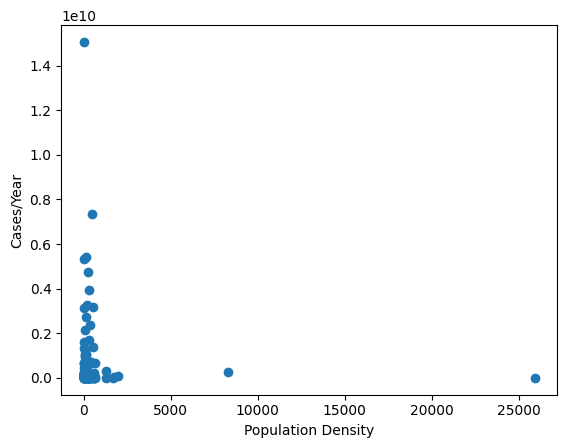

In [219]:
x = LRdata['Country People/Sq Km']
y = LRdata['Slope between 2020 and 2022']
plt.scatter(x,y)
plt.xlabel('Population Density')
plt.ylabel('Cases/Year')
plt.show()

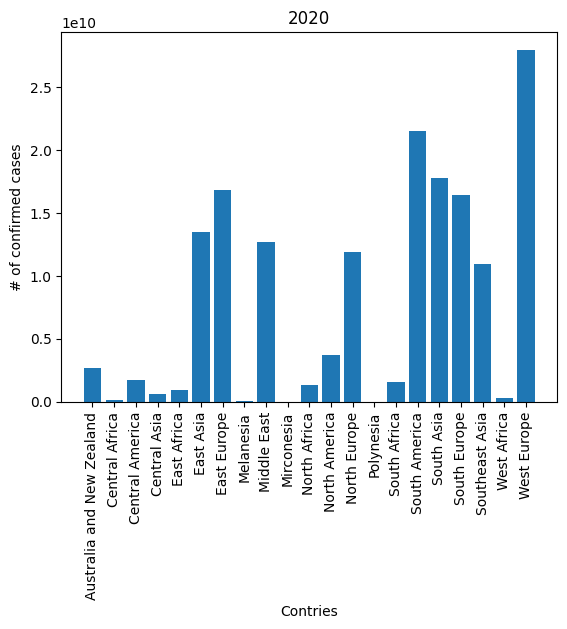

In [83]:
plt.bar(cleaned['Place'], cleaned[2022])


plt.xlabel('Contries')
plt.ylabel('# of confirmed cases')
plt.title('2020')
plt.xticks(rotation = 90)

plt.show()

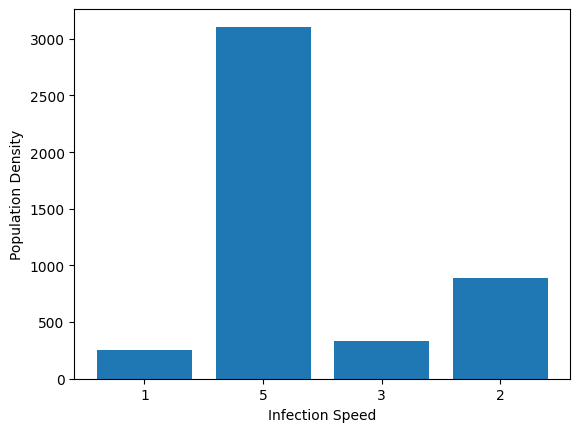

In [84]:
plt.bar(dropcords['Infection Speed'], dropcords['Avg People/Sq Km'])
plt.xlabel('Infection Speed')
plt.ylabel('Population Density')
plt.show()

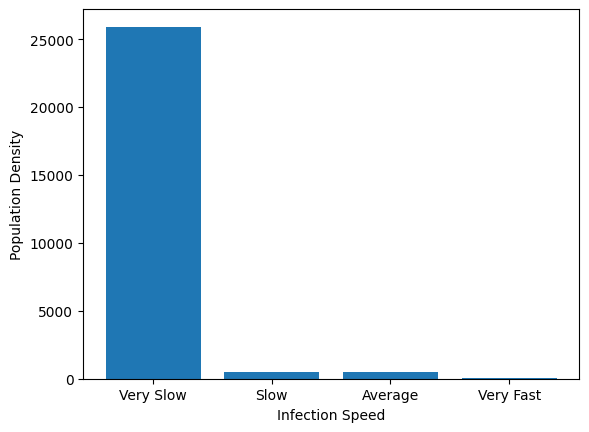

In [238]:
plt.bar(LRdata['Infection Speed'], LRdata['Country People/Sq Km'])
plt.xlabel('Infection Speed')
plt.ylabel('Population Density')
plt.show()